# Setup

## Connect Google Drive Folder

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imports

In [169]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, MaxPooling1D, SimpleRNN, Attention
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

## Primary Variables

Filepath variables

In [4]:
cwk_dir ="drive/MyDrive/NLU Coursework/"

data_dir = os.path.join(cwk_dir, "data")

solution_dir = os.path.join(cwk_dir, "solution B")
models_dir = os.path.join(solution_dir, "models")
results_dir = os.path.join(solution_dir, "results")

In [5]:
TRAIN_FILEPATH: str = os.path.join(data_dir, "training_data/training_data/NLI")
TRAIN_DATASET: str = os.path.join(TRAIN_FILEPATH, "train.csv")
DEV_DATASET: str = os.path.join(TRAIN_FILEPATH, "dev.csv")

TRIAL_FILEPATH: str = os.path.join(data_dir, "trial_data/trial_data")
TRIAL_DATASET: str = os.path.join(TRIAL_FILEPATH, "NLI_trial.csv")

Label variables

In [6]:
PREMISE_KEY: str = "premise"
HYPOTHESIS_KEY: str = "hypothesis"
LABEL_KEY: str = "label"

Preprocessing variables

In [57]:
LOWER: bool = True
PADDING: str = "post"

nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training variables

In [87]:
INITIAL_LR: float = 1e-3
EPOCHS: int = 10
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 128

DROPOUT: float = 0.25

# OPTIMIZER = RMSprop(INITIAL_LR)
OPTIMIZER = "adam"

Other

In [105]:
MAX_SEQ_LENGTH: int = 50 #None is the value to denote that there is no max length. Max length is recommended
VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = 300

## Functions

In [128]:
def load_data_csv(filepath: str) -> typing.Tuple[typing.List[str], typing.List[str], typing.List[int]]:
  """
  Will load in data from the filepath specified. Expects the string filepath to a csv file. Returns tuple of the premises, hypotheses and labels
  """
  dataset = pd.read_csv(filepath).to_dict()
  premises = list(map(str, dataset[PREMISE_KEY].values()))
  hypotheses = list(map(str, dataset[HYPOTHESIS_KEY].values()))
  labels = list(map(int, dataset[LABEL_KEY].values()))
  return (premises, hypotheses,labels)

In [129]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [130]:
def tokenize_data(tokenizer: Tokenizer, premises: typing.List[str], hypotheses: typing.List[str], maxlen: int = None) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = tokenizer.texts_to_sequences(premises)
  hypotheses = tokenizer.texts_to_sequences(hypotheses)

  premises = pad_sequences(premises, maxlen=MAX_SEQ_LENGTH, padding=PADDING)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_SEQ_LENGTH, padding=PADDING)

  return (np.array(premises), np.array(hypotheses))

In [131]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [132]:
def clean_sentences(sentences: typing.List[str]) -> typing.List[str]:
  """
  Takes a list of sentences & cleans them. Remove stopwords primarily
  """
  sentences = [[word for word in sentence.split(" ") if word not in STOP_WORDS] for sentence in sentences]
  return [" ".join(sentence) for sentence in sentences]

In [135]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [179]:
train_premises, train_hypotheses, train_labels = load_data_csv(filepath=TRAIN_DATASET)
dev_premises, dev_hypotheses, dev_labels = load_data_csv(filepath=DEV_DATASET)

In [180]:
train_labels = np.array(train_labels).reshape(len(train_labels),1)
dev_labels = np.array(dev_labels).reshape(len(dev_labels),1)

In [181]:
#Removes stop words
train_premises = clean_sentences(sentences=train_premises)
train_hypotheses = clean_sentences(sentences=train_hypotheses)

dev_premises = clean_sentences(sentences=dev_premises)
dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

## Tokenize Data

In [182]:
tokenizer = Tokenizer(lower=LOWER) #Automatically sets sentence to lower & removes punctuation
tokenizer.fit_on_texts(train_premises + train_hypotheses + dev_premises + dev_hypotheses)

In [183]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=train_premises, hypotheses=train_hypotheses, maxlen=MAX_SEQ_LENGTH)
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=dev_premises, hypotheses=dev_hypotheses, maxlen=MAX_SEQ_LENGTH)

In [184]:
if(MAX_SEQ_LENGTH is None):
  MAX_SEQ_LENGTH = max(max([len(sample) for sample in train_hypotheses]), max([len(sample) for sample in train_premises]), max([len(sample) for sample in dev_premises]), max([len(sample) for sample in dev_hypotheses]))
print(f"Max sequence length: {MAX_SEQ_LENGTH}")

Max sequence length: 50


Example of a sentence:

In [185]:
print(f"Sentence: {tokenizer.sequences_to_texts([train_premises[0]])}")
print(f"Tokens: {train_premises[0][:50]}")

Sentence: ['however fort charles rebuilt military naval garrison protected jamaica much english caribbean 250 years advent steamships yet another earthquake 1907 saw decline']
Tokens: [  299  1974  1539  3016   602  5297  8461  3485  2326    34   585  3298
  4700    31  9191 27105   368   106  3935 27106   453  1875     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [186]:
VOCAB_SIZE = num_words = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 40415


## Embedding Matrix

In [114]:
### Will use word2vec to create an embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_SIZE))

nltk.download('punkt')
if("word2vec" in locals()):
  word2vec = api.load('word2vec-google-news-300')

for word, index in tokenizer.word_index.items():
  try:
      embedding_matrix[index, :] = word2vec[word]
  except KeyError:
    pass
print(f"Embeddings shape: {embedding_matrix.shape}")

# Model Training

## Model Architecture

In [188]:
input_premises = Input(shape=(MAX_SEQ_LENGTH,))
input_hypotheses = Input(shape=(MAX_SEQ_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, input_length = MAX_SEQ_LENGTH, weights=[embedding_matrix], trainable=False)

premises = embedding_layer(input_premises)
premises = Bidirectional(LSTM(64, return_sequences=True, dropout=DROPOUT))(premises)
premises = BatchNormalization()(premises)
premises = Flatten()(premises)

hypotheses = embedding_layer(input_hypotheses)
hypotheses = Bidirectional(LSTM(64, return_sequences=True, dropout=DROPOUT))(hypotheses)
hypotheses = BatchNormalization()(hypotheses)
hypotheses = Flatten()(hypotheses)

merged = concatenate([premises, hypotheses], axis=-1)

x = Dense(2048, activation='relu')(merged)
x = Dropout(DROPOUT)(x)
x = BatchNormalization()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(DROPOUT)(x)
x = BatchNormalization()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(DROPOUT)(x)
x = BatchNormalization()(x)

output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

show_model_architecture(model=model, filename="model_architecture.png")

ValueError: Layer embedding_31 weight shape (40415, 300) is not compatible with provided weight shape torch.Size([30522, 768]).

## Model Training

In [178]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/10
169/169 [==============================] - 14s 37ms/step - loss: 0.6831 - accuracy: 0.5966 - val_loss: 0.6419 - val_accuracy: 0.6300
Epoch 2/10
169/169 [==============================] - 4s 24ms/step - loss: 0.5106 - accuracy: 0.7455 - val_loss: 0.6551 - val_accuracy: 0.6194
Epoch 3/10
169/169 [==============================] - 5s 28ms/step - loss: 0.2829 - accuracy: 0.8748 - val_loss: 0.8623 - val_accuracy: 0.5649
Epoch 4/10
169/169 [==============================] - 4s 24ms/step - loss: 0.1553 - accuracy: 0.9365 - val_loss: 1.5000 - val_accuracy: 0.5925
Epoch 5/10
169/169 [==============================] - 4s 24ms/step - loss: 0.0950 - accuracy: 0.9629 - val_loss: 1.9874 - val_accuracy: 0.5879
Epoch 6/10
134/169 [======================>.......] - ETA: 0s - loss: 0.0732 - accuracy: 0.9734

KeyboardInterrupt: 

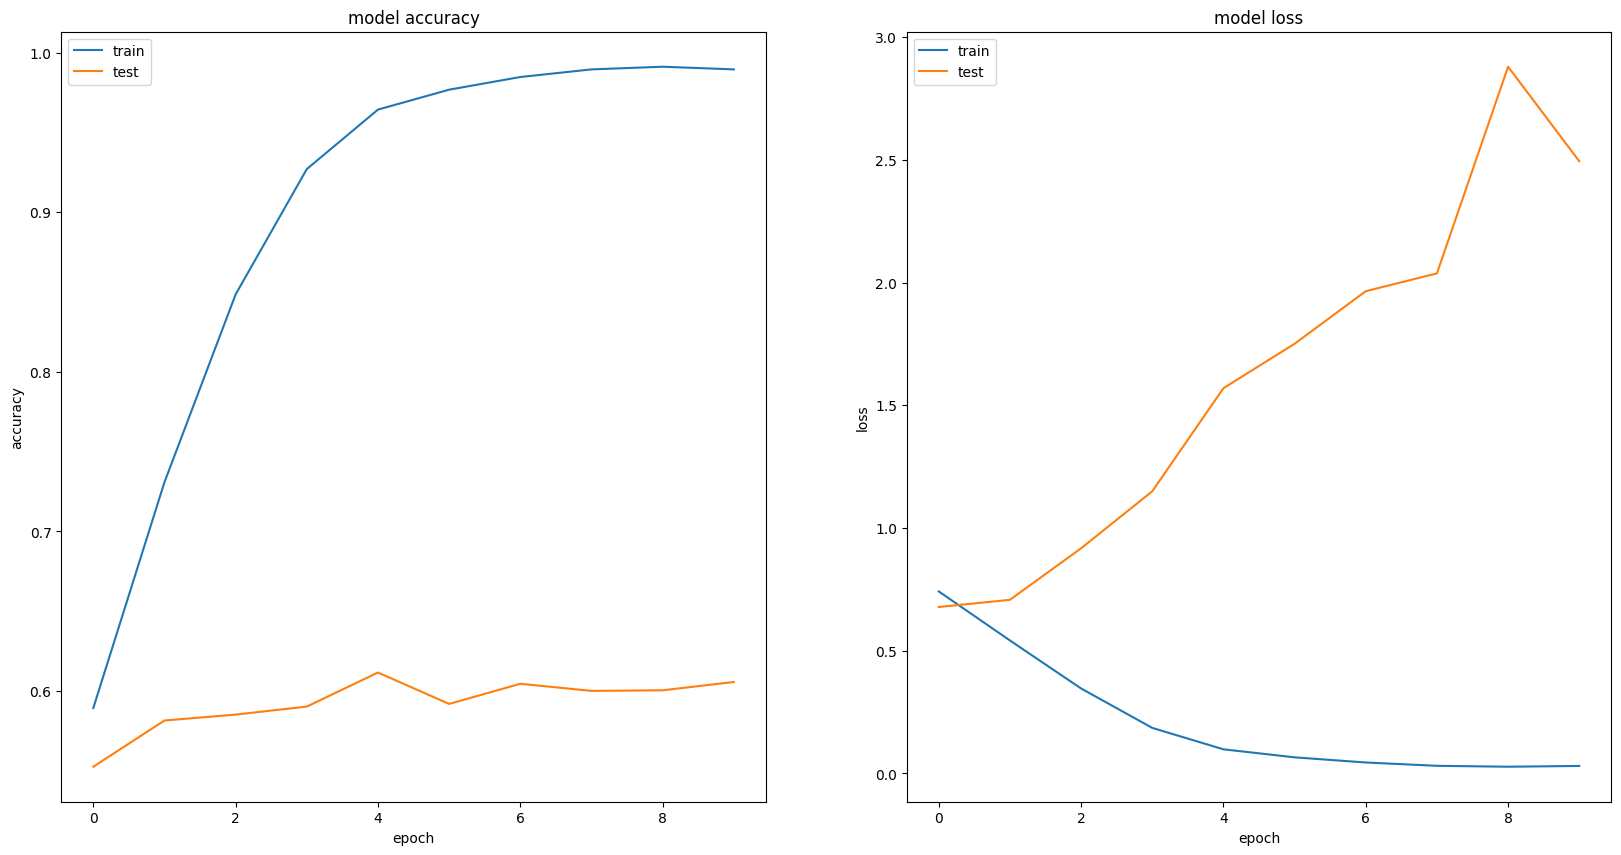

In [146]:
plot_history(history=history, export_path="model_B.pdf")

In [138]:
#Save the model
# save_keras_model(model=model, filename="model_B")

## Model Evaluation

In [163]:
loss, accuracy = model.evaluate([dev_premises, dev_hypotheses], dev_labels)
print("\nTest score/loss:", loss)
print('Test accuracy:', accuracy)

211/211 [==============================] - 1s 6ms/step - loss: 2.8669 - accuracy: 0.5547

Test score/loss: 2.8668737411499023
Test accuracy: 0.5546979308128357
